# Introduction

The notebook is intended to provide several EDA plots for different situations.

In [1]:
# Import Standard Libraries
import os

import pandas as pd
import numpy as np

from itertools import product as cartesian_product

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

import seaborn as sns

from pathlib import Path
from colorama import Style, Fore

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

In [4]:
# Define local data file paths
books_sold_train_file_path = Path(os.path.abspath('')).parents[0] / 'data' / 'books_sold_train.csv'
books_sold_test_file_path = Path(os.path.abspath('')).parents[0] / 'data' / 'books_sold_test.csv'

# Read data
books_sold_train = pd.read_csv(books_sold_train_file_path, parse_dates=['date'], index_col=0)
books_sold_test = pd.read_csv(books_sold_test_file_path, parse_dates=['date'], index_col=0)

# General

## Data Range

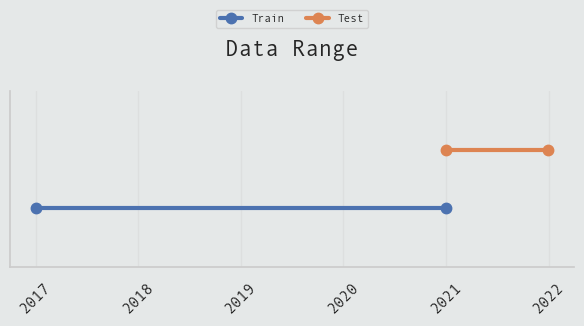

In [5]:
# Compute the min and max time range for train & test data
books_sold_train_range = books_sold_train.date.agg(['min', 'max'])
books_soldtest_range = books_sold_test.date.agg(['min', 'max'])

# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(6, 3))

# Plot the train time range
ax.plot(books_sold_train_range, 
        [0.2, 0.2], 
        linewidth=3, 
        marker='.', 
        markersize=15, 
        label='Train')

# Plot the test time rage
ax.plot(books_soldtest_range, 
        [0.3, 0.3], 
        linewidth=3, 
        marker='.', 
        markersize=15, 
        label='Test')

# Refine plot height
ax.set_ylim(0.1, 0.4)

# Remove the y-ticks since it's not need
ax.set_yticks(ticks=[]);

# Set subplot tick rotation
ax.tick_params(labelrotation=45)
    
# Retrieve legend information
handles = ax.get_legend_handles_labels()[0]
labels = ax.get_legend_handles_labels()[1]
ax.legend().remove()

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.10), 
              fontsize=8,
              ncol=len(handles))

# Set figure Title
figure.suptitle('Data Range',
                fontweight='bold',
                fontsize=16)

plt.tight_layout()

## Seasonality

In [13]:
def plot_seasonality(data: pd.DataFrame, 
                     seasonality_column: str, 
                     ci:int = 95, 
                     alpha: int = 1):
    """
    Plot the specified data with respect to the 'seasonality_column'
    
    Args:
        data: Pandas.DataFrame of data to plot
        seasonality_column: String column name of the seasonality column
        ci: Integer confidence interval value
        alpha: Integer alpha value

    Returns:
        Seasonality pllot
    """
    
    # Define figure and axes
    figure, ax = plt.subplots(4, 2, figsize=(18, 20))
    ax = ax.flatten()

    # Define the lines category order
    hue_order = data['country'].unique()
    
    
    # Compute every possible combination between the other two categories
    products = data['product'].unique()
    stores = data['store'].unique()
    iterator = cartesian_product(products, stores)
    
    # Fetch the data to plot
    for index, (product, store) in enumerate(iterator):
        
        # Retrieve the data to plot
        data_plot = data[
            (data['store'] == store) &
            (data['product'] == product)]
    
        # Plot the data
        sns.lineplot(
            data=pd.melt(
                data_plot, 
                id_vars=['country', seasonality_column],
                value_vars=['num_sold'],
                value_name='num_solds'
            ),
            x=seasonality_column,
            y='num_solds',
            hue='country',
            ax=ax[index],
            errorbar=('ci', ci),
            alpha=alpha,
            hue_order=hue_order
        )
        
        # Set subplot title
        ax[index].set_title(f'{store} | {product}', 
                            fontsize=10)
        
        # Retrieve legend information
        handles = ax[index].get_legend_handles_labels()[0]
        labels = ax[index].get_legend_handles_labels()[1]
        ax[index].legend().remove()

    # Set the legend
    figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=data['country'].nunique())
                         
    # Set figure title
    plt.suptitle(f'Seasonality by {seasonality_column}',
                 fontweight='bold',
                 fontsize=16)
    
    plt.tight_layout()
    
    plt.show() 

In [14]:
def engineer_date(data: pd.DataFrame):
    """
    Engineer the 'date' column to retrieve meaningful information such as the day, month, year, day of week, quarter, day of year and week of year
    
    Parameters:
        data: Pandas DataFrame with the 'date' column
    
    Return:
        data: Pandas DataFrame with the engineered date columns
    """
    
    # Day
    data['day'] = data['date'].dt.day
    
    # Month
    data['month'] = data['date'].dt.month
    
    # Year
    data['year'] = data['date'].dt.year
    
    # Day of the week
    data['dayofweek'] = data['date'].dt.dayofweek
    
    # Quarter
    data['quarter'] = data['date'].dt.quarter
    
    # Day of the year
    data['dayofyear'] = data['date'].dt.dayofyear
    
    # Week of the year
    data['weekofyear'] = data['date'].dt.isocalendar().week
    data.loc[data['weekofyear'] > 52, 'weekofyear'] = 52 # Not every year has 53 weeks, so let's cap to 52
    data['weekofyear'] = data['weekofyear'].astype('int64') # Convert back the column to integer

    return data

In [15]:
books_sold_train_engineered = engineer_date(books_sold_train)

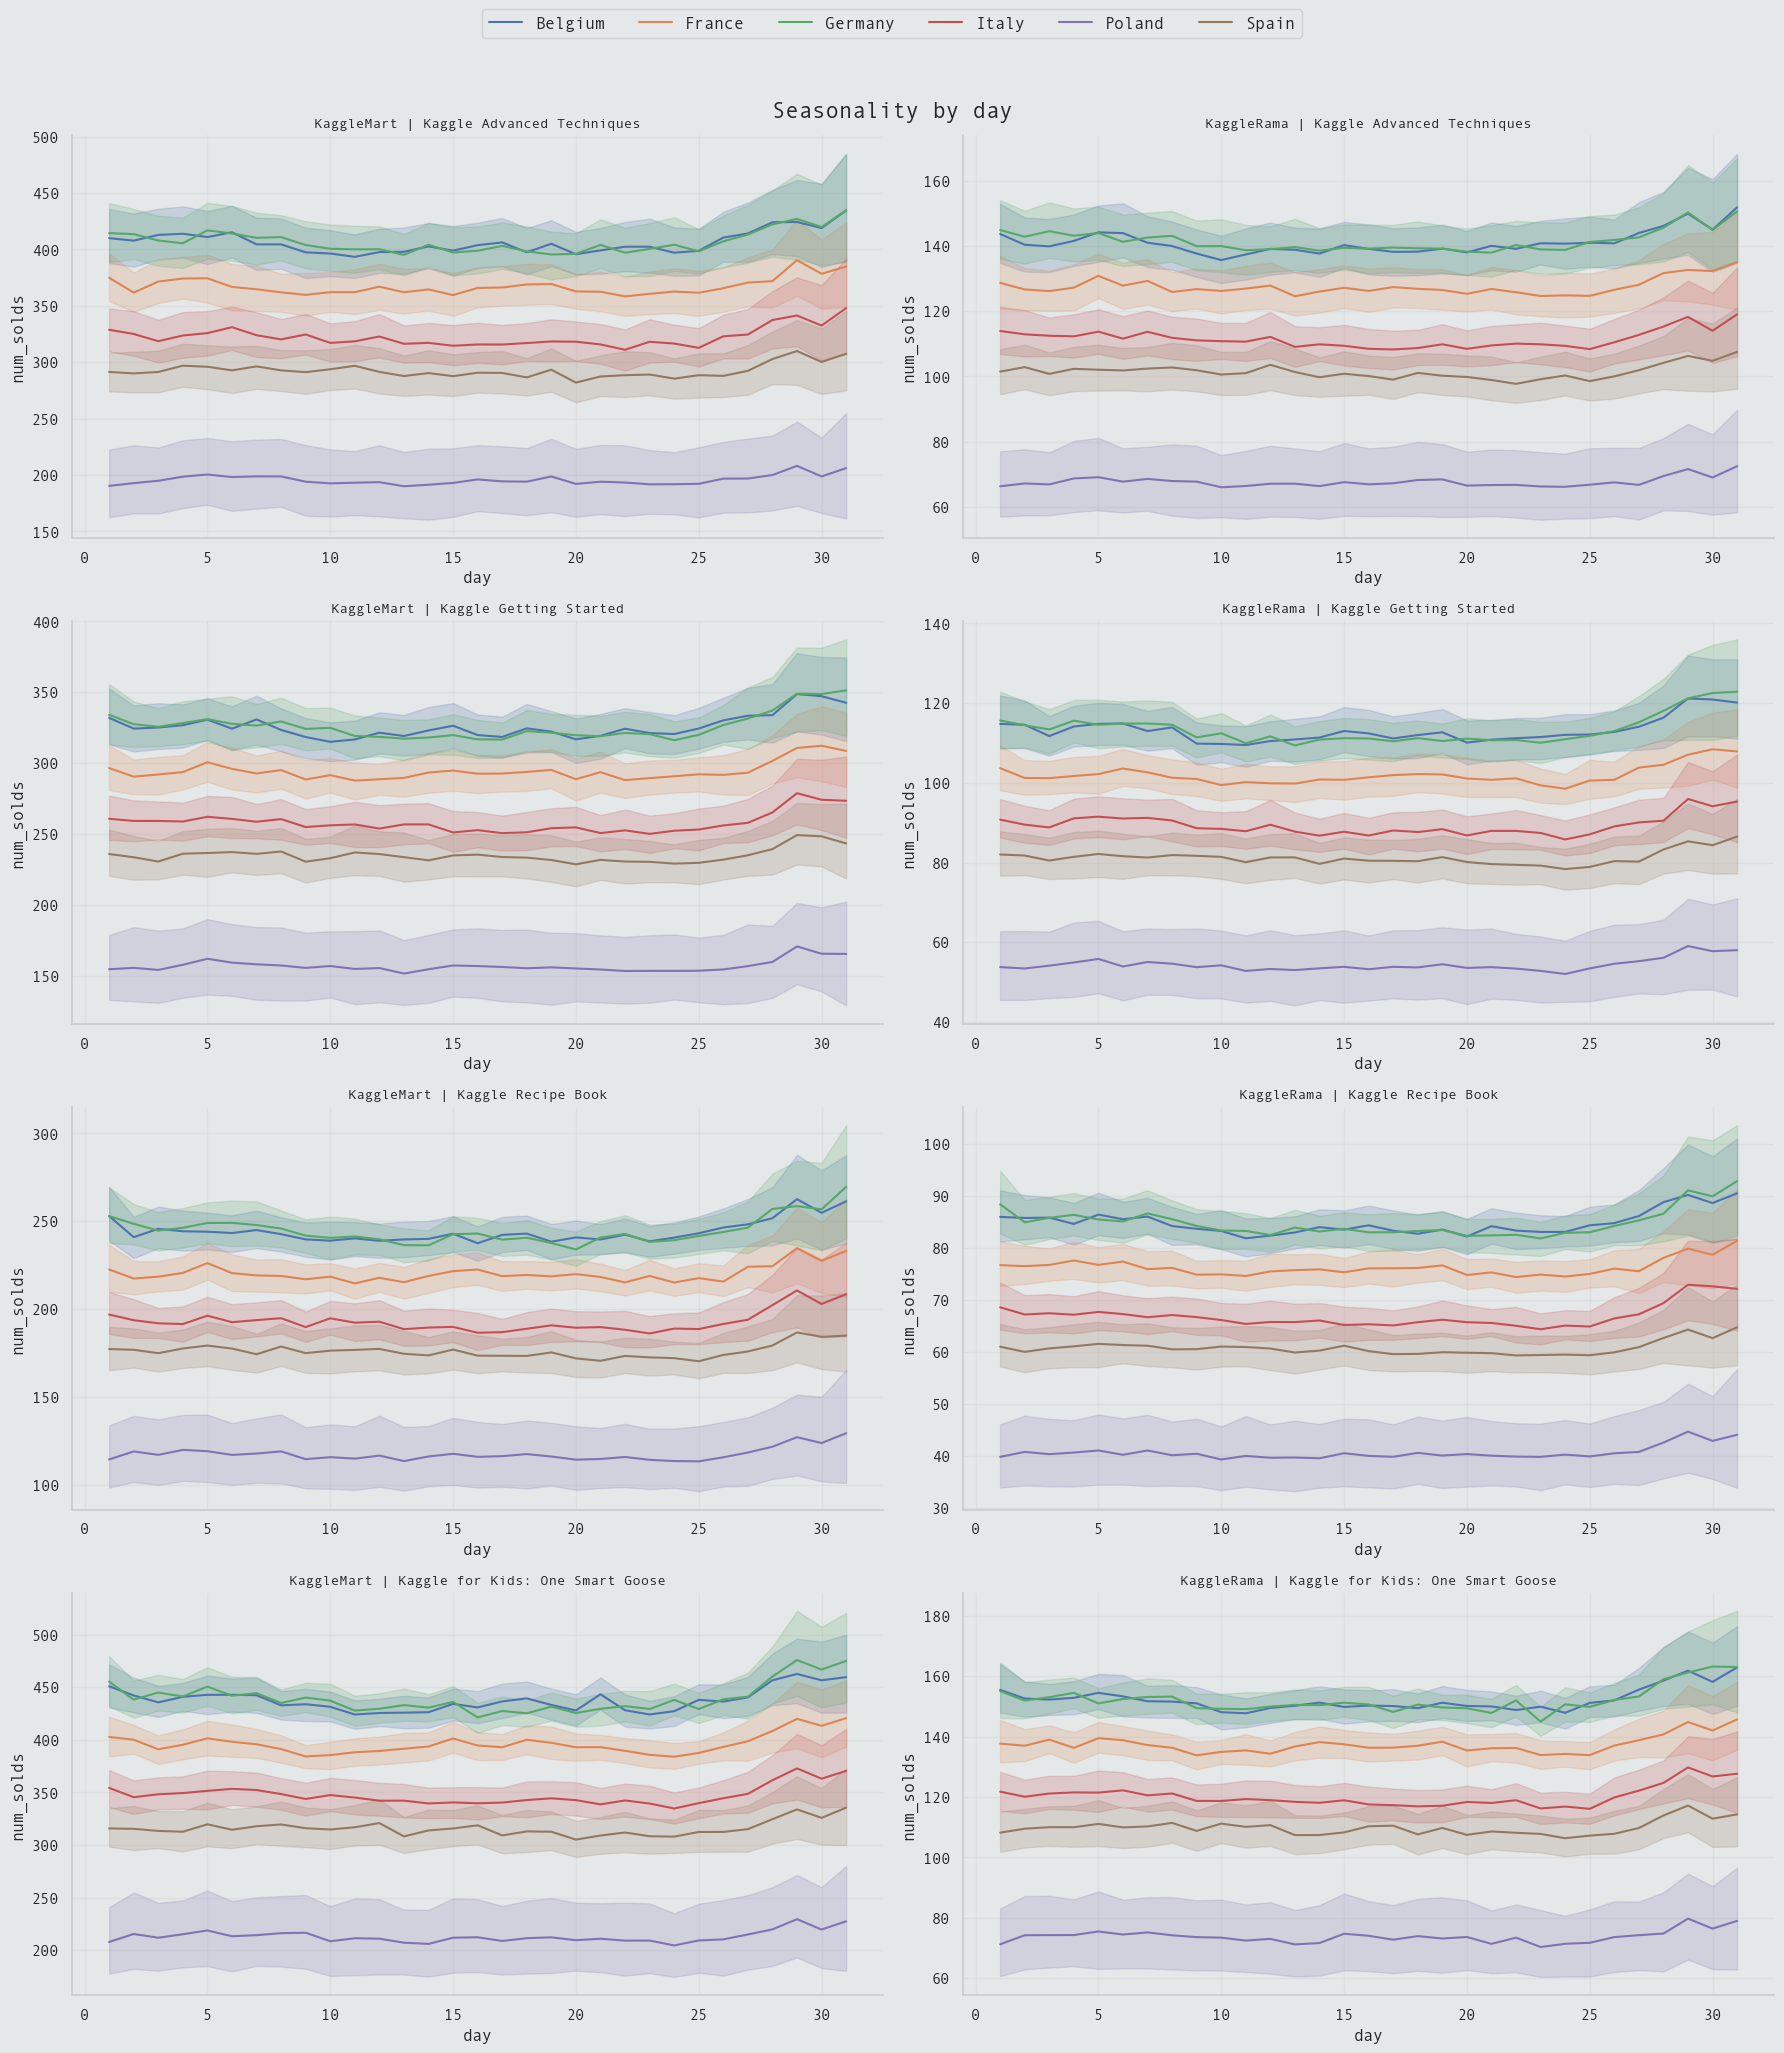

In [16]:
plot_seasonality(books_sold_train_engineered, 'day')

# Numerical Variables

## Barplot per Category

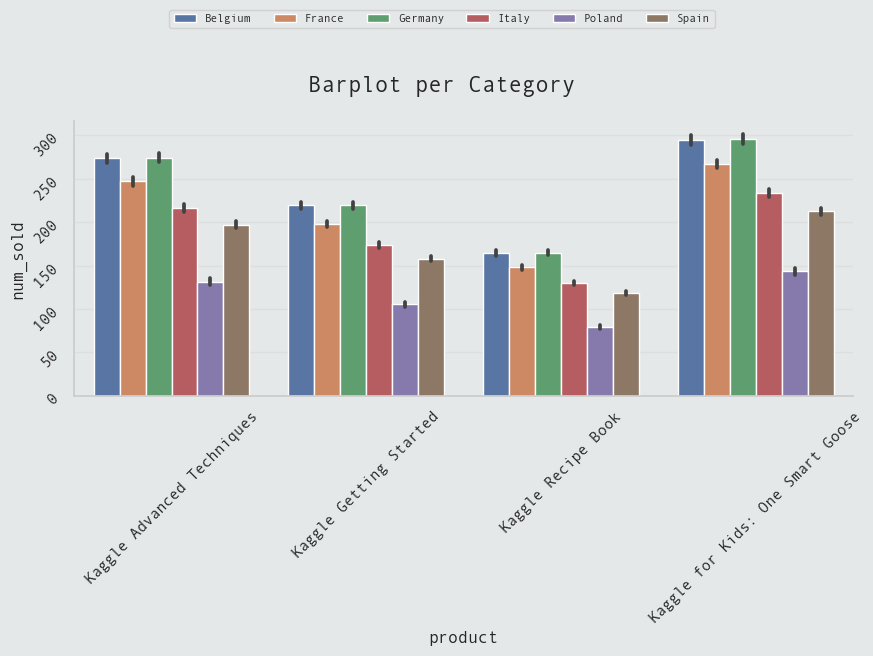

In [8]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(9, 6))

# Plot the barplot
sns.barplot(data=books_sold_train,
            x='product',
            y='num_sold',
            hue='country')
    
# Set subplot tick rotation
ax.tick_params(labelrotation=45)
    
# Retrieve legend information
handles = ax.get_legend_handles_labels()[0]
labels = ax.get_legend_handles_labels()[1]
ax.legend().remove()

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.10), 
              fontsize=8,
              ncol=len(handles))

# Set figure Title
figure.suptitle('Barplot per Category',
                fontweight='bold',
                fontsize=16)

plt.tight_layout()

## Lineplot per Category over Time

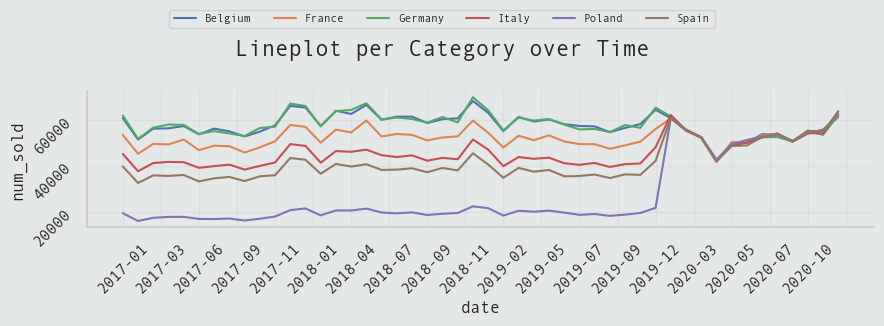

In [9]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(9, 3))

# Plot the Lineplot
sns.lineplot(
    data=books_sold_train.groupby([
        books_sold_train.date.dt.strftime('%Y-%m'), 
        books_sold_train.country])['num_sold'].sum().reset_index(),
    x='date',
    y='num_sold',
    hue='country')
    
# Set subplot tick rotation
ax.tick_params(labelrotation=45)

# Set x axis ticks
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=books_sold_train.date.dt.strftime('%Y-%m').nunique()/2))
    
# Retrieve legend information
handles = ax.get_legend_handles_labels()[0]
labels = ax.get_legend_handles_labels()[1]
ax.legend().remove()

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.10), 
              fontsize=8,
              ncol=len(handles))

# Set figure Title
figure.suptitle('Lineplot per Category over Time',
                fontweight='bold',
                fontsize=16)

plt.tight_layout()

## Lineplot per Multiple Categories over Time

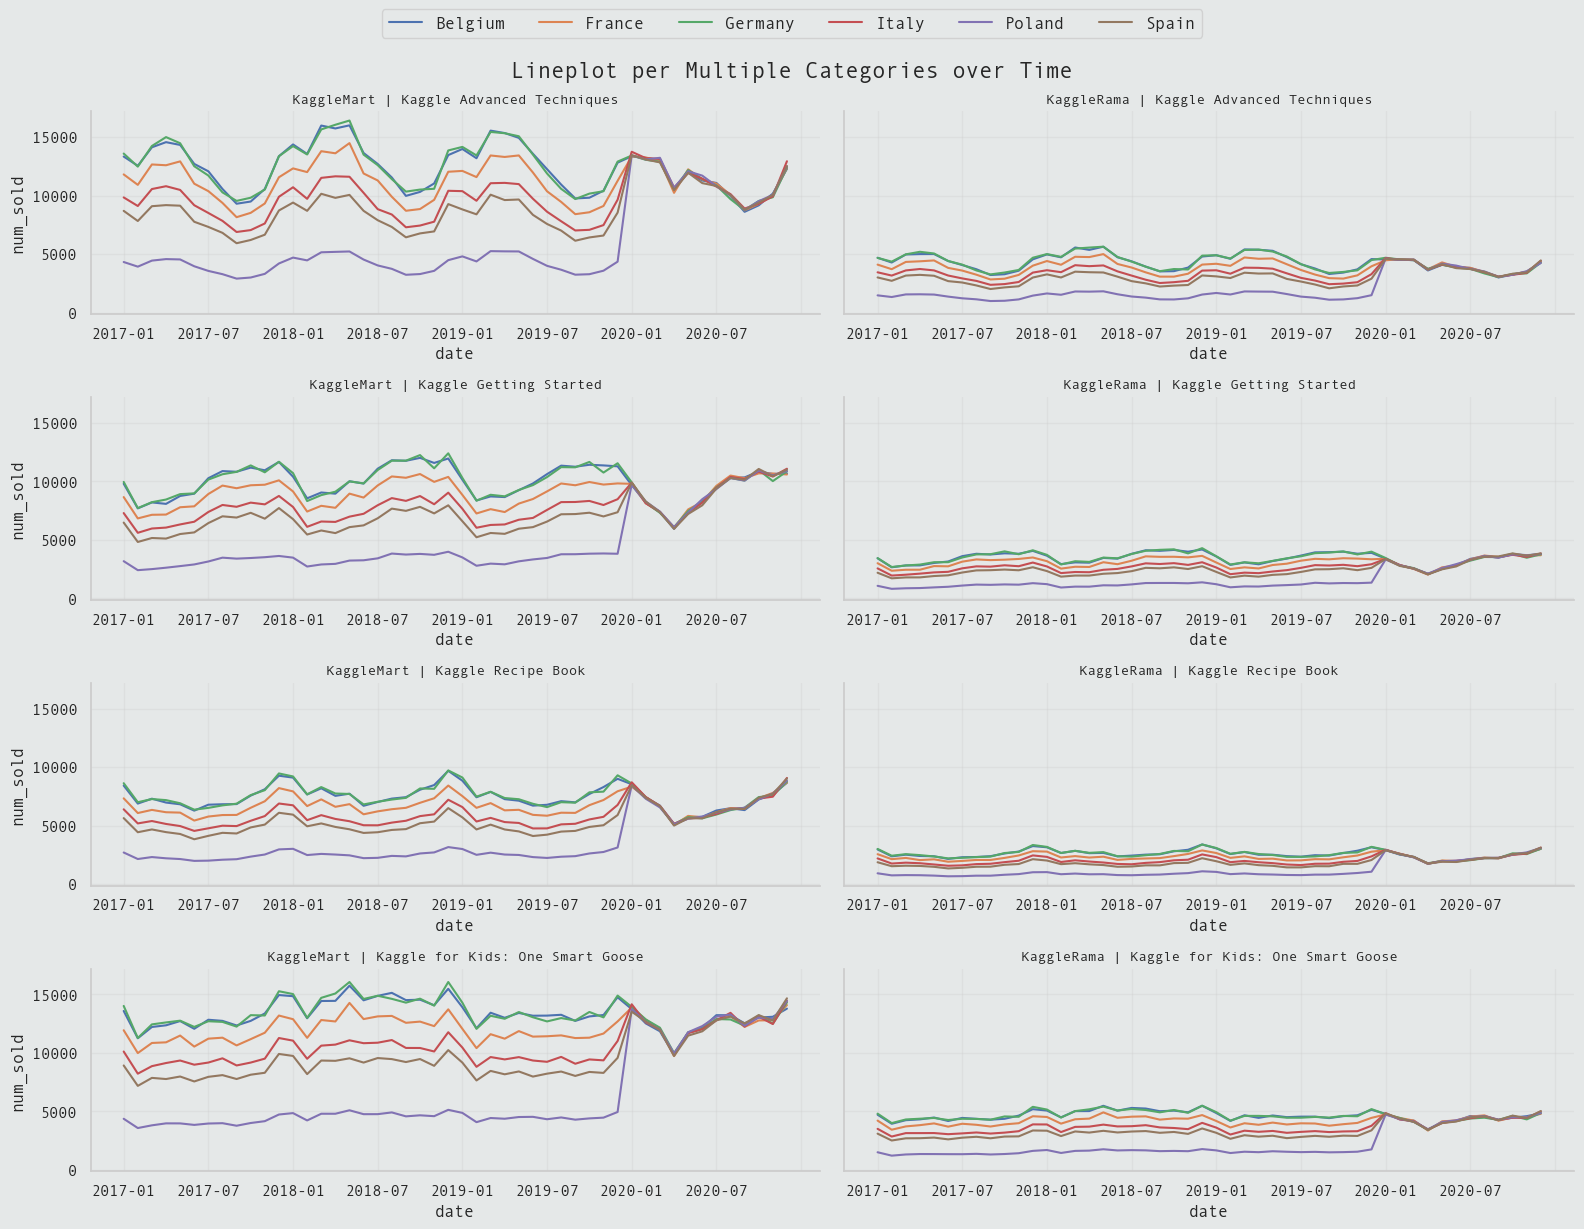

In [10]:
# Define figure and axes
figure, ax = plt.subplots(4, 2, figsize=(16, 12), sharey=True)
ax = ax.flatten()

# Define the lines category order
hue_order = books_sold_train['country'].unique()

# Compute every possible combination between the other two categories
products = books_sold_train['product'].unique()
stores = books_sold_train['store'].unique()
iterator = cartesian_product(products, stores)

# Fetch the data to plot
for index, (product, store) in enumerate(iterator):
    
    # Retrieve the data to plot
    data_plot = books_sold_train[
        (books_sold_train['store'] == store) &
        (books_sold_train['product'] == product)]
    
    # Plot the data
    sns.lineplot(
        data=data_plot.groupby([
            data_plot.date.dt.strftime('%Y-%m'), 
            data_plot.country
        ])['num_sold'].sum().reset_index(),
        x='date',
        y='num_sold',
        hue='country',
        hue_order=hue_order,
        ax=ax[index])
    
    # Set subplot title
    ax[index].set_title(f'{store} | {product}', 
                        fontsize=10)
    
    # Set x axis ticks
    ax[index].xaxis.set_major_locator(ticker.MaxNLocator(nbins=data_plot.date.dt.strftime('%Y-%m').nunique()/5))
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=books_sold_train['country'].nunique())

# Set figure Title
figure.suptitle('Lineplot per Multiple Categories over Time',
                fontweight='bold',
                fontsize=16)
    
plt.tight_layout()                 

# Categorical Variables